Inspired by

https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=9ff47fbb

https://arxiv.org/pdf/2102.09672

https://arxiv.org/pdf/2006.11239

https://colab.research.google.com/github/LinXueyuanStdio/PyTorch-DDPM/blob/master/DDPM.ipynb#scrollTo=f08c1e18

In [ ]:
%%capture
!pip install torchcfm

In [ ]:
%%capture
%load_ext autoreload
%autoreload 2

import os
import math
import numpy as np
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
import torchvision
from torchcfm.models.unet import UNetModel

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%%capture

batch_size = 128 #@param {'type':'number'}

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_dataset = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transformations
)

train_data_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [ ]:
#@title hyperparameters and model

num_res_blocks = 3 #@param {'type':'number'}
num_channels = 64 #@param {'type':'number'}
learning_rate = 0.0002 #@param {'type':'number'}

model = UNetModel(dim=(1, 28, 28), num_channels=num_channels, num_res_blocks=num_res_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#@title schedulers

def linear_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)

    alphas_bar = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]

    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return torch.clip(betas, 0, 0.999)

In [ ]:
#@title diffusion setup

class diffusion:
  def __init__(self, steps = 1000, schedule = "cosine") -> None:
      if schedule == "cosine":
        self.betas = cosine_schedule(steps)
      else:
        self.betas = linear_schedule(steps)

      self.steps = steps
      self.alphas = 1. - self.betas
      self.alphas_bar = torch.cumprod(self.alphas, axis=0)
      self.alphas_bar_prev = torch.cat([torch.tensor([1.0]), self.alphas_bar[:-1]])
      self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
      self.sqrt_one_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)

      #forward
      self.sqrt_recip_alphas_bar = torch.sqrt(1.0 / self.alphas_bar)
      self.sqrt_recip_m1_alphas_bar = torch.sqrt(1.0 / self.alphas_bar - 1)

      #backward, found in eq 10 of improved ddpm paper
      self.post_var = self.betas * (1.0 - self.alphas_bar_prev) / (1.0 - self.alphas_bar)
      self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_bar_prev) / (1.0 - self.alphas_bar)
      self.posterior_mean_coef2 = (1.0 - self.alphas_bar_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_bar)

  def get_param(self, a, t, shape):
      batch_size = t.shape[0]
      selected_values = torch.index_select(a.to(t.device), 0, t).float()
      reshaped_values = selected_values.view(batch_size, *([1] * (len(shape) - 1)))
      return reshaped_values

#forward
  def get_forward_mean_var(self, x_0, t):
    #from eq 8 of improved ddpm paper
    sqrt_alphas_bar_t = self.get_param(self.sqrt_alphas_bar, t, x_0.shape)
    sqrt_one_minus_alphas_bar_t = self.get_param(self.sqrt_one_minus_alphas_bar, t, x_0.shape)
    return sqrt_alphas_bar_t * x_0, sqrt_one_minus_alphas_bar_t

  def forward(self, x_0, t, noise):
    #sample from forward
    mean, var = self.get_forward_mean_var(x_0, t)

    return mean + torch.sqrt(var) * noise

#backward
  def get_reverse_mean_var(self, x_0, x_t, t):
    #from eqj 7 of original ddpm paper
    post_mean = self.get_param(self.posterior_mean_coef1, t, x_t.shape) * x_0 + self.get_param(self.posterior_mean_coef2, t, x_t.shape) * x_t
    post_var = self.get_param(self.post_var, t, x_t.shape)
    return post_mean, post_var

  def get_post_reverse_mean_var(self, model, x_t, t,):
    #eq 9 from improved ddpm rearranged, eg rearrange for x_0 in terms of x_t and estimate eps with network
    noise_est = model(t,x_t)
    x_orig = self.get_param(self.sqrt_recip_alphas_bar, t, x_t.shape) * x_t - self.get_param(self.sqrt_recip_m1_alphas_bar, t, x_t.shape) * noise_est

    x_orig = torch.clamp(x_orig, min=-1.0, max=1.0)
    post_mean, post_var = self.get_reverse_mean_var(x_orig, x_t, t)
    return post_mean, post_var

#sampling
  @torch.no_grad()
  def step(self, model, x_t: torch.FloatTensor, t: torch.LongTensor, clip_denoised=True):
      #takes a step in the denoising process
      mean, var = self.get_post_reverse_mean_var(model, x_t, t)
      noise = torch.randn_like(x_t)
      nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1)))
      pred_img = mean + nonzero_mask * torch.sqrt(var) * noise
      return pred_img


In [ ]:
#@title initialisation

T = 1000 #@param

diff = diffusion(steps=T, schedule = "linear")

In [ ]:
#@title training

epochs = 50 #@param
lossfunc = nn.MSELoss()

for epoch in range(epochs):
    for i, (images, _) in enumerate(tqdm(train_data_loader, desc="Batches", leave=False)):
        optimizer.zero_grad()

        images = images.to(device)

        batch_size = images.shape[0]
        t = torch.randint(0, T, (batch_size,), device=device)

        noise = torch.randn_like(images)
        x_noisy = diff.forward(images, t, noise=noise)
        predicted_noise = model(t, x_noisy)
        loss = lossfunc(noise, predicted_noise)

        loss.backward()
        optimizer.step()
    print(epoch)


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


In [ ]:
final_checkpoint_path = '/content/drive/My Drive/Dissertation/models/ddpm_final_linear_3res_50epoch_64chan.pth'
torch.save(model.state_dict(), final_checkpoint_path)
print(f'Saved final model checkpoint: {final_checkpoint_path}')

Saved final model checkpoint: /content/drive/My Drive/Dissertation/models/ddpm_final_linear_3res_50epoch_32chan.pth


In [ ]:
%%capture
final_checkpoint_path = '/content/drive/My Drive/Dissertation/models/ddpm_final_3res_50epoch_64chan.pth'
model.load_state_dict(torch.load(final_checkpoint_path, map_location=device))
model.eval()

In [ ]:
#@title sampling

@torch.no_grad()
def sample(diff, model, image_size, num_samples):
    shape = (num_samples, 1, image_size, image_size)
    device = next(model.parameters()).device

    img = torch.randn(shape, device=device)
    for i in tqdm(reversed(range(0, diff.steps)), desc="sampling", total=diff.steps):
        t = torch.full((num_samples,), i, device=device, dtype=torch.long)
        img = diff.step(model, img, t)

    return img.cpu().numpy()


In [ ]:
def plot_image_grid(images, num_samples, image_size, figsize=(12, 12)):
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    axes = axes.flatten()

    images_to_plot = images.clip(0,1)

    for i in range(num_samples):
        axes[i].imshow(images_to_plot[i], cmap="gray")
        axes[i].axis("off")

    for ax in axes[num_samples:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
num_samples = 100
image_size = 28

generated_images = sample(diff, model, image_size, num_samples=num_samples)

sampling: 100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


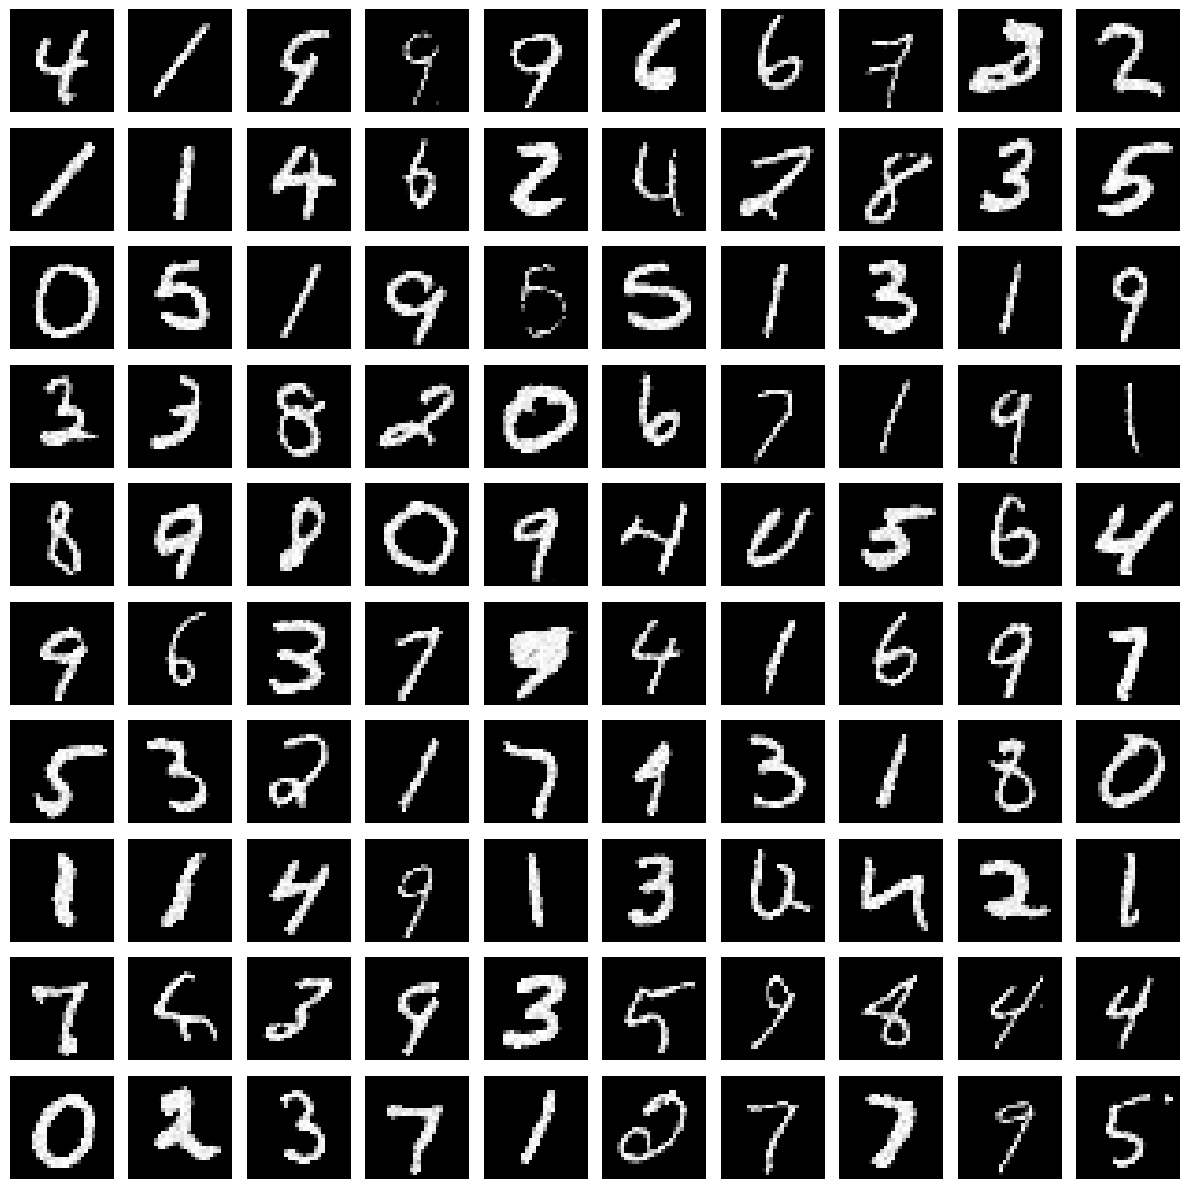

In [ ]:
images = generated_images.reshape(num_samples, image_size, image_size)

plot_image_grid(images, num_samples, image_size)

In [ ]:
#@title Sampling for FID

num_images = 10000 #@param {'type':'integer'}
batch_size = 100  #@param {'type':'integer'}
start_index = 100 #@param {'type':'integer'}
save_dir = "/content/drive/My Drive/Dissertation/images/DDPM_linear"

os.makedirs(save_dir, exist_ok=True)

to_pil = ToPILImage()

with torch.no_grad():
    for start_idx in range(start_index, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        current_batch_size = end_idx - start_idx

        images = sample(diff, model, image_size, num_samples=current_batch_size)

        images = images.reshape(current_batch_size, image_size, image_size)

        images = images.clip(0,1)

        for i, img in enumerate(images):
            img = to_pil(img)
            img.save(os.path.join(save_dir, f"sample_{start_idx + i + 1}.png"))

sampling: 100%|██████████| 1000/1000 [01:34<00:00, 10.55it/s]
